#### Attention is All You Need 실습 코드
* 본 코드는 기본적으로 **Transformer** 논문의 내용을 최대한 따릅니다.

#### **데이터 전처리(Preprocessing)**

* **spaCy 라이브러리**: 문장의 토큰화(tokenization), 태깅(tagging) 등의 전처리 기능을 위한 라이브러리
  * 영어(Engilsh)와 독일어(Deutsch) 전처리 모듈 설치

In [1]:
import spacy

# spacy.blank 대신 미리 학습된 모델 로드
spacy_en = spacy.load('en_core_web_sm')
spacy_de = spacy.load('de_core_news_sm')


In [2]:
# 간단히 토큰화(tokenization) 기능 써보기
tokenized = spacy_en.tokenizer("I am a graduate student.")

for i, token in enumerate(tokenized):
    print(f"인덱스 {i}: {token.text}")

인덱스 0: I
인덱스 1: am
인덱스 2: a
인덱스 3: graduate
인덱스 4: student
인덱스 5: .


* 영어(English) 및 독일어(Deutsch) **토큰화 함수** 정의

In [3]:
# 독일어(Deutsch) 문장을 토큰화 하는 함수 (순서를 뒤집지 않음)
def tokenize_de(text):
    return [token.text for token in spacy_de.tokenizer(text)]

# 영어(English) 문장을 토큰화 하는 함수
def tokenize_en(text):
    return [token.text for token in spacy_en.tokenizer(text)]

* 번역 목표
    * 소스(SRC): 독일어
    * 목표(TRG): 영어

대표적인 영어-독어 번역 데이터셋인 **Multi30k**를 불러옵니다.
- test 데이터가 제대로 압축이 풀리지 않는 문제가 있어 직접 풀어줘야 합니다. 
- ~/.cache/torch/text/datasets/Multi30k 경로로 이동
- tar -zxvf mmt16_task1_test.tar.gz 실행

In [4]:
import torch
from torchtext.datasets import Multi30k
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

In [5]:
train_dataset = Multi30k(split='train', language_pair=('de', 'en'))
valid_dataset = Multi30k(split='valid', language_pair=('de', 'en'))
test_dataset = Multi30k(split='test', language_pair=('de', 'en'))


# 2. 어휘장(Vocabulary) 생성
def yield_tokens(data_iter, tokenizer, index):
    for de_text, en_text in data_iter:
        if index == 0:
            yield tokenizer(de_text) # yield를 사용하면 모든 데이터를 메모리에 올리지 않고 효율적으로 처리
        else:
            yield tokenizer(en_text) # yield를 사용하면 모든 데이터를 메모리에 올리지 않고 효율적으로 처리
            
# 특수 토큰 정의
special_symbols = ['<unk>', '<pad>', '<sos>', '<eos>']
UNK_IDX, PAD_IDX, SOS_IDX, EOS_IDX = 0, 1, 2, 3

# 독일어(SRC)와 영어(TRG) 어휘장 생성
# build_vocab_from_iterator는 토큰들의 반복자(iterator)를 받아 어휘장을 만듭니다.
vocab_src = build_vocab_from_iterator(yield_tokens(train_dataset, tokenize_de, 0),
                                      min_freq=2, # 단어가 어휘장에 포함되기 위한 최소 등장 빈도를 설정합니다. 최소 2번이상 등장한 단어만 추가. 오타 및 희귀한 다넝 제외하여 어휘장의 크기를 적절히 유지하고 일반화 성능을 높임.
                                      specials=special_symbols, # 위에서 정의한 특수 토큰들을 어휘장에 추가하라고 지시합니다.
                                      special_first=True) # 특수 토큰들이 어휘장의 맨 앞에 위치하도록(인덱스 0, 1, 2, 3) 설정합니다.
vocab_trg = build_vocab_from_iterator(yield_tokens(train_dataset, tokenize_en, 1),
                                      min_freq=2,
                                      specials=special_symbols,
                                      special_first=True)



/home/ternary6/anaconda3/envs/rd_env/lib/python3.11/site-packages/torch/utils/data/datapipes/iter/combining.py:337: UserWarning: Some child DataPipes are not exhausted when __iter__ is called. We are resetting the buffer and each child DataPipe will read from the start again.
  warnings.warn("Some child DataPipes are not exhausted when __iter__ is called. We are resetting "


In [6]:
from tqdm import tqdm

max_src_len = 0
max_trg_len = 0

print("학습 데이터셋의 최대 문장 길이 계산")

# train_dataset을 순회하며 각 문장의 길이를 확인
for src_text, trg_text in tqdm(train_dataset):
    # 각 문장을 토큰화하고 토큰의 개수를 계산
    src_len = len(tokenize_de(src_text))
    trg_len = len(tokenize_en(trg_text))
    
    # 현재 최대 길이보다 길면 값을 업데이트
    if src_len > max_src_len:
        max_src_len = src_len
        
    if trg_len > max_trg_len:
        max_trg_len = trg_len

print(f"\n소스(독일어) 문장의 최대 토큰 길이: {max_src_len}")
print(f"타겟(영어) 문장의 최대 토큰 길이: {max_trg_len}")

학습 데이터셋의 최대 문장 길이 계산


29001it [00:00, 34020.26it/s]


소스(독일어) 문장의 최대 토큰 길이: 44
타겟(영어) 문장의 최대 토큰 길이: 41


In [7]:
print(f"독일어 vocab 갯수 : {len(vocab_src.vocab)}")
print(f"15번 인덱스 단어: {vocab_src.lookup_token(15)}")
print('==='*10)
print(f"영어 vocab 갯수 : {len(vocab_trg.vocab)}")
print(f"hello의 인덱스 : {vocab_trg['hello']}")


독일어 vocab 갯수 : 8014
15번 인덱스 단어: ein
영어 vocab 갯수 : 6191
hello의 인덱스 : 5465


In [8]:
# <unk> 토큰에 대한 기본 인덱스 설정
# 모르는 단어가 나오면 에러를 발생시키지 말고, 우리가 <unk> 토큰에 부여한 인덱스(UNK_IDX, 보통 0)를 대신 반환해라
vocab_src.set_default_index(UNK_IDX)
vocab_trg.set_default_index(UNK_IDX)

# 3. 배치(Batch) 처리를 위한 함수 정의 (collate_fn)
# 데이터로더가 만들어준 원시 데이터 묶음(batch)을 받아, 모델이 학습할 수 있는 최종 텐서 형태로 가공하는 함수입니다
def collate_fn(batch):
    src_batch, trg_batch = [], []
    for src_sample, trg_sample in batch:
        # 텍스트 -> 토큰화 -> 수치화 (어휘장 인덱스) -> sos/eos 토큰 추가
        # torch.long은 PyTorch에서 사용하는 데이터 타입(data type) 중 하나로, 64비트 크기의 부호 있는 정수를 의미합니다.
        src_batch.append(torch.tensor([SOS_IDX] + vocab_src(tokenize_de(src_sample)) + [EOS_IDX], dtype=torch.long))
        trg_batch.append(torch.tensor([SOS_IDX] + vocab_trg(tokenize_en(trg_sample)) + [EOS_IDX], dtype=torch.long))
    
    # 각 문장의 길이가 다르므로 <pad> 토큰으로 길이를 맞춰줍니다.
    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX, batch_first=True)
    trg_batch = pad_sequence(trg_batch, padding_value=PAD_IDX, batch_first=True)
    return src_batch, trg_batch

# 4. DataLoader 생성
BATCH_SIZE = 128
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn)

# 사용 예시
for src, trg in train_dataloader:
    print("학습 Source 배치 모양:", src.shape) # 예: [128, 30] -> batch_first=True
    print("학습 Target 배치 모양:", trg.shape) # 예: [128, 32]
    print('현재 학습 데이터 배치에 있는 하나의 문장에 포함된 정보 출력')
    for i in range(src.shape[1]):
        print(f"인덱스 {i}: {src[0][i].item()}") # 여기에서는 [Seq_num, Seq_len]
    break

    
for src, trg in valid_dataloader:
    print("\n검증 Source 배치 모양:", src.shape) # 예: [128, 30] -> batch_first=True
    print("검증 Target 배치 모양:", trg.shape) # 예: [128, 32]
    break

for src, trg in test_dataloader:
    print("\n테스트 Source 배치 모양:", src.shape) # 예: [128, 30] -> batch_first=True
    print("테스트 Target 배치 모양:", trg.shape) # 예: [128, 32]
    break
    

    



학습 Source 배치 모양: torch.Size([128, 27])
학습 Target 배치 모양: torch.Size([128, 24])
현재 학습 데이터 배치에 있는 하나의 문장에 포함된 정보 출력
인덱스 0: 2
인덱스 1: 21
인덱스 2: 85
인덱스 3: 257
인덱스 4: 31
인덱스 5: 87
인덱스 6: 22
인덱스 7: 94
인덱스 8: 7
인덱스 9: 16
인덱스 10: 112
인덱스 11: 7910
인덱스 12: 3209
인덱스 13: 4
인덱스 14: 3
인덱스 15: 1
인덱스 16: 1
인덱스 17: 1
인덱스 18: 1
인덱스 19: 1
인덱스 20: 1
인덱스 21: 1
인덱스 22: 1
인덱스 23: 1
인덱스 24: 1
인덱스 25: 1
인덱스 26: 1

검증 Source 배치 모양: torch.Size([128, 35])
검증 Target 배치 모양: torch.Size([128, 30])

테스트 Source 배치 모양: torch.Size([128, 29])
테스트 Target 배치 모양: torch.Size([128, 31])


#### **Multi Head Attention 아키텍처**

* 어텐션(attention)은 <b>세 가지 요소</b>를 입력으로 받습니다.
    * <b>쿼리(queries)</b>
    * <b>키(keys)</b>
    * <b>값(values)</b>
    * 현재 구현에서는 Query, Key, Value의 차원이 모두 같습니다.
* 하이퍼 파라미터(hyperparameter)
    * **hidden_dim**: 하나의 단어에 대한 임베딩 차원
    * **n_heads**: 헤드(head)의 개수 = scaled dot-product attention의 개수
    * **dropout_ratio**: 드롭아웃(dropout) 비율

In [9]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

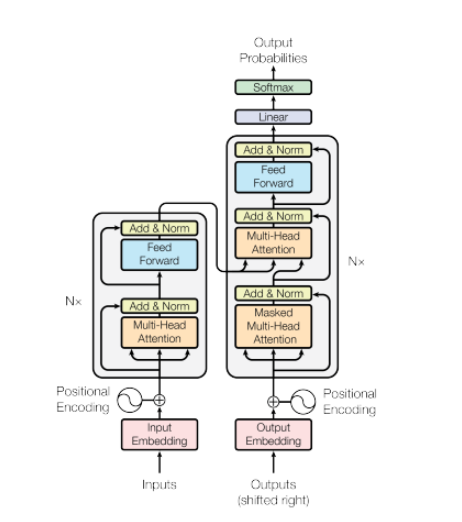

### MultiHeadAttentionLayer

nn.Module(부모) - MultiHeadAttentionLayer (자식)

#### class로 구현하는 이유
- 그룹화 및 재사용성: 클래스는 레이어의 상태(state)와 행동(behavior)을 하나의 단위로 묶어줍니다. 여기서 상태는 학습되어야 할 가중치(weight)와 편향(bias) 같은 파라미터들이고, 행동은 입력 데이터가 들어왔을 때 수행하는 연산(forward 메서드)입니다. 이렇게 묶어두면 MultiHeadAttentionLayer라는 class를 다른 곳에서 쉽게 가져다 쓸 수 있습니다.


- PyTorch 프레임워크와의 통합: PyTorch의 모든 모델과 레이어는 nn.Module 클래스를 상속받아 만들어집니다. class MultiHeadAttentionLayer(nn.Module)처럼 구현하면, PyTorch가 제공하는 강력한 기능들(파라미터 추적, GPU/CPU 이동, 모델 저장/로드 등)을 자동으로 활용할 수 있습니다.

#### def __init__(self, ...)와 super().__init__()를 사용하는 이유
- __init__ (생성자): 이 메서드는 클래스의 객체(인스턴스)가 처음 생성될 때 단 한 번 호출됩니다. 주된 역할은 레이어에서 사용할 부품들(다른 레이어, 변수 등)을 미리 정의하고 초기화하는 것입니다. nn.Linear나 nn.Dropout처럼 학습이 필요한 파라미터를 가진 레이어들은 여기서 선언되어야 PyTorch가 추적하고 학습시킬 수 있습니다.


- super() : 부모 클래스의 메서드를 호출하는 파이썬 내장 함수로, 부모 클래스의 내용에 접근할 수 있게 해주는 역할을 함.

- super().__init__(): 가장 중요한 라인 중 하나입니다. 우리 클래스는 nn.Module이라는 부모 클래스를 상속받았습니다. super().__init__()는 이 부모 클래스의 생성자를 먼저 호출하는 역할을 합니다. 이 부모 생성자가 모델의 파라미터를 등록하고 추적하는 등의 모든 보이지 않는 중요한 설정 작업을 수행합니다. 즉, 부모가 해야 할 기본적인 설정 작업을 수행하고, 그 이후에 자식 클래스만의 설정을 추가하겠다는 의미입니다. self.fc_q를 추가해주는 것과 말이죠. 만약 이 줄을 생략하면 PyTorch는 이 클래스를 정상적인 레이어로 인식하지 못해 학습이 이루어지지 않습니다.

#### PyTorch는 super().__init__()를 어떻게 인식하고 처리하는가?
nn.Module의 __init__ 메서드 안에 모델 관리에 필수적인 코드들이 프로그래밍되어 있기 때문입니다. super().__init__()를 호출하면, nn.Module의 __init__ 메서드가 실행되면서 모든 nn.Module 객체 내부에 다음과 같은 중요한 저장 공간(내부 딕셔너리)들을 생성합니다.
- self._parameters: 모델의 학습 가능한 파라미터(e.g., nn.Parameter)를 등록하는 공간
- self._modules: 모델이 포함하는 하위 레이어(e.g., nn.Linear, nn.Dropout)들을 등록하는 공간
- self._buffers: 학습되지는 않지만 모델의 상태로 저장되어야 하는 텐서(e.g., 배치 정규화의 running_mean)를 등록하는 공간

인식 및 처리 과정
1. super().__init__() 실행: 우리 모델 객체 내부에 비어있는 _modules 딕셔너리가 생성됩니다.

2. self.fc_q = nn.Linear(...) 실행: 우리가 정의한 nn.Linear 레이어를 self.fc_q라는 속성에 할당합니다.

3. PyTorch의 자동 등록: nn.Module은 이 할당 과정을 지켜보다가, 할당된 값이 또 다른 nn.Module(여기서는 nn.Linear)인 것을 감지합니다.

4. _modules에 추가: PyTorch는 fc_q라는 이름과 nn.Linear 객체를 1번 단계에서 만들어 둔 _modules 딕셔너리에 {'fc_q': Linear(...)} 와 같이 자동으로 추가합니다.

이 과정 덕분에 나중에 model.parameters()나 model.to(device)를 호출하면, PyTorch는 _modules 딕셔너리를 보고 등록된 모든 하위 레이어를 찾아 요청한 작업을 재귀적으로 수행해 줄 수 있습니다.

만약 super().__init__()를 생략하면 _modules 딕셔너리 자체가 생성되지 않으므로, self.fc_q는 그냥 평범한 파이썬 속성으로만 남게 되고 PyTorch의 관리 시스템에 등록되지 않아 학습이 불가능해집니다.

#### assert를 사용하는 이유
- 방어적 프로그래밍: assert는 특정 조건이 참(True)인지 검사하고, 만약 거짓(False)이면 AssertionError를 발생시켜 프로그램을 즉시 중단시킵니다.

- 오류 조기 발견: 코드의 assert hidden_dim % n_heads == 0 라인은 hidden_dim이 n_heads로 나누어떨어지는지 확인합니다. 멀티 헤드 어텐션은 hidden_dim을 n_heads 개수만큼 똑같이 쪼개서 사용하기 때문에, 이 조건은 논리적으로 반드시 만족해야 합니다. 만약 사용자가 hidden_dim=512, n_heads=10과 같이 잘못된 값을 입력하면, 복잡한 텐서 연산 중간에 알 수 없는 오류가 발생하는 대신, 모델 생성 시점에서 "이 설정은 잘못되었습니다"라고 명확하게 알려주어 버그를 쉽게 잡을 수 있게 합니다.

### 실습 코드 파라미터
HIDDEN_DIM = 256

n_heads = 8

head_dim = 256 // 8 = 32

In [10]:
import torch.nn as nn

class MultiHeadAttentionLayer(nn.Module): # 부모-자식 관계 정의
    def __init__(self, hidden_dim, n_heads, dropout_ratio, device):
        super().__init__() # 이 객체에 추가되는 레이어들은

        assert hidden_dim % n_heads == 0

        self.hidden_dim = hidden_dim # 임베딩 차원.  다른 어텐션(attention) 컨셉의 수. # 8 
        self.head_dim = hidden_dim // n_heads # 각 헤드(head)에서의 임베딩 차원 # 256 // 8 = 32  
        
        # 각각 Query, Key, Value를 만들기 위한 FC(Fully-Connected) 레이어. 
        # 입력으로 들어온 임베딩 벡터를 각 역할에 맞게 projection하는 역할을 함. 이 레이어들의 가중치가 실질적으로 학습되는 파라미터.
        self.fc_q = nn.Linear(hidden_dim, hidden_dim) # Query 값에 적용될 FC 레이어
        self.fc_k = nn.Linear(hidden_dim, hidden_dim) # Key 값에 적용될 FC 레이어256
        self.n_heads = n_heads # 헤드(head)의 개수: 서로
        self.fc_v = nn.Linear(hidden_dim, hidden_dim) # Value 값에 적용될 FC 레이어

        self.fc_o = nn.Linear(hidden_dim, hidden_dim) # 각 헤드에서 계산된 어텐션 결과들을 모두 합친 후, 마지막으로 거치는 출력 FC 레이어. Input 차원과 동일하게 맞춰주는 역할도 함.

        self.dropout = nn.Dropout(dropout_ratio) # 어텐션 스코어에 드롭아웃을 적용하여 모델의 과적합을 방지. 

        # 어텐션 에너지 값을 head_dim(d_k)의 제곱근으로 나눠준 스케일링 인자. 
        # 분산이 너무 커져 기울기 소실 문제를 방지하기 위함. 표준편차인 sart(d_k)로 나누어 분산을 1 근처로 안정시키는 것을 기대함.
        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)
        

    def forward(self, query, key, value, mask = None): # 실제 데이터가 입력되었을 때 멀티 헤드 어텐션이 계산되는 과정.

        batch_size = query.shape[0]

        # query: [batch_size, query_len, 256]
        # key: [batch_size, key_len, 256]
        # value: [batch_size, value_len, 256]
        # 셀프 어텐션인 경우 query, key, value의 길이는 동일함. 인코더 - 디코더 어텐션의 경우 인코더의 출력이 k,v로 사용되고 디코더 셀프 어텐션의 출력이 q로 사용되므로 길이가 다름.
 
        # 각 역할에 맞는 Q, K, V 텐서 생성
        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)

        # Q: [batch_size, query_len, 256]
        # K: [batch_size, key_len, 256]
        # V: [batch_size, value_len, 256]

        # hidden_dim → n_heads X head_dim 형태로 변형
        # n_heads(h)개의 서로 다른 어텐션(attention) 컨셉을 학습하도록 유도
        # view(= reshape. 모양 바꾸기)의 -1 부분은 PyTorch가 알아서 계산해주기 때문에, 배배치 크기(batch size)나 문장 길이(sequence length)처럼 크기가 동적으로 변할 수 있는 차원을 다룰 때 유용.
        # permute(= 차원 순서 바꾸기) [배치, 헤드, 문장 길이, 헤드 차원] 순서로 만들어, 각 헤드별로 (문장 길이, 헤드 차원) 모양의 행렬곱을 효율적으로 수행할 수 있게 하기 위함.
        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)

        # Q: [batch_size, 8, query_len, 32]
        # K: [batch_size, 8, key_len, 32]
        # V: [batch_size, 8, value_len, 32]

        # Attention Energy 계산
        # Q와 K의 마지막 두 차원에 대해 행렬 곱을 수행.
        # (query_len, 32) x (32, key_len) -> (query_len, key_len)
        # Q와 K의 전치 행렬을 곱함. Scaled Dot-Product Attention의 핵심인 "Dot-Product"
        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale

        # energy: [batch_size, 8, query_len, key_len]
        # 마스크를 적용해야 한다면 여기에 적용해야함. 그래서 마스크는 브로드캐스팅이 가능해야 하므로 [batch_size,seq_len]의 1,2차원에 차원을 추가하여 [batch_size, 1, 1, seq_len]이 되어야 함.

        # 마스크(mask)를 사용하는 경우
        if mask is not None:
            # 마스크(mask) 값이 0인 부분을 -1e10으로 채우기
            energy = energy.masked_fill(mask==0, -1e10)

        # 어텐션(attention) 스코어 계산: 각 단어에 대한 확률 값
        # dim=-1: 마지막 차원(축)의 위치를 가리킴. x의 마지막 차원(가로 방향)을 따라 각 그룹의 합이 1이 되도록 확률을 계산
        attention = torch.softmax(energy, dim=-1)

        # attention: [batch_size, 8, query_len, key_len]

        # 여기에서 Scaled Dot-Product Attention을 계산
        # (query_len, key_len) x (value_len, 32) -> (query_len, 32)
        # (이때 key_len과 value_len은 항상 같습니다)
        # 어텐션 확률을 Value 텐서에 곱해 가중합(weighted sum)을 구합니다. 이것이 바로 문맥을 압축한 결과 벡터입니다.
        x = torch.matmul(self.dropout(attention), V)

        # x: [batch_size, 8, query_len, 32]
        
        # 헤드들을 다시 결합하기 위해 차원 순서를 원래대로 되돌립니다. 각 헤드별 energy, score행렬곱 수행을 위해 [배치, 헤드, 문장 길이, 헤드 차원]를 만든 -> [배치, 문장길이, 헤드, 헤드 차원]로 다시 복원.
        # contiguous() : PyTorch는 효율성을 위해 실제로 데이터를 메모리에서 재배치하지 않습니다. permute()나 transpose() 실행 후 에는 순서를 바꿔 펼쳐 놓은 상태와 같음. 이러한 상태를 non-contiguous라고 합니다.
        # .view()은 데이터를 모양으로 재구성하기 위해, 데이터가 반드시 순서대로 놓인 형태일 것을 요구하나, non-contiguous 상태에서는 각 원소의 메모리 주소만 바꿔서 보여주기 때문에 메모리 상에는 데이터가 흩어져 있음.
        # 그래서 contiguous를 통해 흩어진 각 원소들을 메모리의 한 공간에 순서대로 복사하여 새로운 contiguous 텐서로 만들어 주어야 함. 이미 contiguous 상태라면 그대로 반환함.
        x = x.permute(0, 2, 1, 3).contiguous()

        # x: [batch_size, query_len, 8, 32]

        # n_heads(8)와 head_dim(32) 차원을 다시 hidden_dim(256)으로 합칩니다.
        x = x.view(batch_size, -1, self.hidden_dim)

        # x: [batch_size, query_len, 256]

        # 최종 출력 FC 레이어를 통과시킵니다.
        x = self.fc_o(x) # (query_len,256) x (256,256)

        # x: [batch_size, query_len, 256]

        return x, attention

#### **Position-wise Feedforward 아키텍처**

* 입력과 출력의 차원이 동일합니다.
* 하이퍼 파라미터(hyperparameter)
    * **hidden_dim**: 하나의 단어에 대한 임베딩 차원
    * **pf_dim**: Feedforward 레이어에서의 내부 임베딩 차원
    * **dropout_ratio**: 드롭아웃(dropout) 비율

In [11]:
class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hidden_dim, pf_dim, dropout_ratio):
        super().__init__()

        self.fc_1 = nn.Linear(hidden_dim, pf_dim) # 256, 512
        self.fc_2 = nn.Linear(pf_dim, hidden_dim) # 512, 256

        self.dropout = nn.Dropout(dropout_ratio)

    def forward(self, x):

        # x: [batch_size, seq_len, hidden_dim]

        x = self.dropout(torch.relu(self.fc_1(x))) # 512차원으로 확장, ReLU로 비선형성 추가. 

        # x: [batch_size, seq_len, pf_dim]

        x = self.fc_2(x)

        # x: [batch_size, seq_len, hidden_dim]

        return x

#### **인코더(Encoder) 레이어 아키텍처**

* 하나의 인코더 레이어에 대해 정의합니다.
    * 입력과 출력의 차원이 같습니다.
    * 이러한 특징을 이용해 트랜스포머의 인코더는 인코더 레이어를 여러 번 중첩해 사용합니다.
* 하이퍼 파라미터(hyperparameter)
    * **hidden_dim**: 하나의 단어에 대한 임베딩 차원
    * **n_heads**: 헤드(head)의 개수 = scaled dot-product attention의 개수
    * **pf_dim**: Feedforward 레이어에서의 내부 임베딩 차원
    * **dropout_ratio**: 드롭아웃(dropout) 비율
* &lt;pad&gt; 토큰에 대하여 마스크(mask) 값을 0으로 설정합니다.

In [12]:
class EncoderLayer(nn.Module):
    def __init__(self, hidden_dim, n_heads, pf_dim, dropout_ratio, device):
        super().__init__()

        # hidden_dim에 해당하는 256개의 특징(feature)들에 대해 평균과 분산을 계산하여 정규화를 수행
        # 배치에 있는 각 문장의 각 단어 벡터(256차원)는 독립적으로 정규화 됨. 즉, 한 단어의 256개 숫자들의 평균은 0, 분산은 1이 되도록 만들어 줍
        # 내부 파라미터 eps=1e-05 : sqrt(variance + eps) 형태로 계산되므로, 분모가 절대 0이 되지 않도록 보장
        # 내부 파라미터 elementwise_affine=True : 레이어 정규화 이후에 학습 가능한 '어파인 변환(affine transformation)'을 적용할지 여부를 결정
        # 데이터를 무조건 평균 0, 분산 1로 강제하는 것이 모델 성능에 항상 좋지는 않음. 그래서 이 옵션을 True로 두면, 모델이 학습 과정에서 스스로 최적의 스케일(gamma)과 이동(beta) 값을 찾아 정규화의 강도를 조절할 수 있는 유연성을 갖을 수 있음.
        
        self.self_attn_layer_norm = nn.LayerNorm(hidden_dim)
        self.ff_layer_norm = nn.LayerNorm(hidden_dim)
        
        
        self.self_attention = MultiHeadAttentionLayer(hidden_dim, n_heads, dropout_ratio, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hidden_dim, pf_dim, dropout_ratio)
        self.dropout = nn.Dropout(dropout_ratio) # 잔차 연결에 사용할 드롭아웃임.

    # 하나의 임베딩이 복제되어 Query, Key, Value로 입력되는 방식
    def forward(self, src, src_mask):

        # src: [batch_size, src_len, hidden_dim]
        # src_mask: [batch_size, src_len]

        # self attention
        # 셀프 어텐션(self-attention)이므로 Query, Key, Value에 모두 동일한 입력 src 사용.
        _src, _ = self.self_attention(src, src, src, src_mask)

        # "Add & Norm"
        # dropout, residual connection and layer norm
        # dropout : 어텐션을 통과한 _src에 드롭아웃을 적용해 과적합을 방지
        # src + _src : 어텐션 이전의 입력 이였던 X.즉 src를 _src에 더해줌으로서, 모델이 깊어져도 그레디언트가 잘 흐르도록 도와 학습을 안정화 시키고 정보 손실으 방지함.
        # attn_layer_norm : 잔차연결까지 마친 결과에 정규화를 수행하여 더해진 src로 인해 출력값이 너무 커지거나 작아지는 것을 방지하여 학습 안정화를 도움.
        src = self.self_attn_layer_norm(src + self.dropout(_src))

        # src: [batch_size, src_len, hidden_dim]

        # position-wise feedforward
        # 첫번째 서브 레이어에서 나온 결과를 입력받아, 비선형 변환을 포함한 확장과 축소를 통해 더 복잡한 표현으로 변환.
        _src = self.positionwise_feedforward(src)

        # "Add & Norm"
        # dropout, residual and layer norm
        # 동일하게 피드포워드 네트워크의 결과에 대해서도 잔차연결과 정규화를 수행.
        src = self.ff_layer_norm(src + self.dropout(_src))

        # src: [batch_size, src_len, hidden_dim]

        return src

#### **인코더(Encoder) 아키텍처**

* 전체 인코더 아키텍처를 정의합니다.
* 하이퍼 파라미터(hyperparameter)
    * **input_dim**: 하나의 단어에 대한 원 핫 인코딩 차원
    * **hidden_dim**: 하나의 단어에 대한 임베딩 차원
    * **n_layers**: 내부적으로 사용할 인코더 레이어의 개수
    * **n_heads**: 헤드(head)의 개수 = scaled dot-product attention의 개수
    * **pf_dim**: Feedforward 레이어에서의 내부 임베딩 차원
    * **dropout_ratio**: 드롭아웃(dropout) 비율
    * **max_length**: 문장 내 최대 단어 개수
* 원본 논문과는 다르게 <b>위치 임베딩(positional embedding)을 학습</b>하는 형태로 구현합니다.
    * BERT와 같은 모던 트랜스포머 아키텍처에서 사용되는 방식입니다.
* &lt;pad&gt; 토큰에 대하여 마스크(mask) 값을 0으로 설정합니다.

#### 포지셔널 인코딩
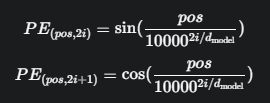

#### 포지셔널 인코딩 지수와 로그로 표현
1. A / B 는 A * (1/B)와 같음-> 그러므로 POS * (1/10000**(2i/d_model)이 가능함.
2. 그리고 1/B는 수학에서 1/x**a = x**-a로 표현이 가능함(지수 법칙) -> 10000**−(2i/d_ model)이 가능해지는 것.
3. 이후 exp 지수함수를 씌워서 log를 취한 값에 exp를 적용해서 x로 되돌림.<br>
-> 컴퓨터가 나눗셈이나 거듭제곱보다 곱셈 연산을 더 빠르고 안정적으로 처리하기 때문이고,<br>
-> 기존 방식은 i 값과 hidden_dim 값에 따라 지수가 매우 크거나 작아질 수 있어, 계산 결과가 불안정해질 위험이 있기 때문임.

- torch.arange(0, max_length, dtype=torch.float) : 이 부분은 0부터 max_length - 1까지의 숫자로 이루어진 1차원 텐서를 생성합니다.
- unsqueeze () : 텐서의 모양(shape)만 바꿔서 차원을 늘려주는 기능. 배치 차원 추가시에는 unsqueeze(0)를 통해 [1, c, h, w]로 구성. unsqueeze(1 또는 -1) [max_length,1]로 바꿔줘서 모양이 다른 텐서끼리 연산할 수 있도록 모양을 맞춰줄 때 사용하는 브로드캐스팅을 위한 것.

In [13]:
# 모델이 처리할 수 있는 모든 위치(0부터 max_length - 1까지)에 대한 고유한 위치 벡터를 미리 한 번에 계산하여 pe (Positional Encoding)라는 행렬에 저장해 둡니다.

class PositionalEncoding(nn.Module):
    def __init__(self, hidden_dim, dropout_ratio, max_length=100):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout_ratio)

        # 위치 인코딩(PE) 행렬을 미리 계산합니다.
        # 크기의 0으로 채워진 텐서를 만들어서 각 위치에 대한 256차원의 벡터를 저장할 공간 확보.
        pe = torch.zeros(max_length, hidden_dim) # [100,256]
        
        # 각 위치(pos)와 차원(i)에 대한 값을 계산할 준비
        # [100,1]
        position = torch.arange(0, max_length, dtype=torch.float).unsqueeze(1) 
        

        # 지수와 로그를 사용한 수식
        div_term = torch.exp(-(math.log(10000.0) * (torch.arange(0,hidden_dim,2,dtype=torch.float)/hidden_dim)))
        
        # 짝수 인덱스에는 sin 함수, 홀수 인덱스에는 cos 함수 적용
        # div_term 결과는 마이너스 부호로 인해 역수인 1/10000**(2i/d_model)가 되므로 곱해주면 됨.
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        
        ## 논문 상의 수식
        # denominator = 10000.0 ** (torch.arange(0, hidden_dim, 2).float() / hidden_dim)
        # pe[:, 0::2] = torch.sin(position / denominator)
        # pe[:, 1::2] = torch.cos(position / denominator)
        
        # pe 텐서에 배치 차원을 추가하고, 버퍼로 등록합니다.
        # 버퍼는 모델의 상태(state_dict)에 포함되어 저장되고 로드되며, .to(device) 호출 시 GPU로 함께 이동합니다
        # 버퍼로 등록된 텐서는 모델의 파라미터로 간주되지 않아 학습 중에 업데이트되지 않습니다.
        # 위치 인코딩 값은 고정되어 있고 학습할 필요가 없으므로 버퍼로 등록하는 것이 올바른 방법
        pe = pe.unsqueeze(0) # 배치 단위 연산을 위해 맨 앞에 배치 차원(크기 1)을 추가하여 [1, max_length, hidden_dim] 모양으로 만듭니다.
        self.register_buffer('pe', pe)

    def forward(self, x):
        # 실제 데이터가 들어왔을 때, 단어 임베딩에 위치 정보를 더해주는 역할을 합니다.
        # x: [batch_size, seq_len, hidden_dim]
        
        # 입력 x에 미리 계산된 위치 인코딩 값을 더합니다.
        # x의 문장 길이(seq_len)만큼만 PE 값을 잘라서 사용합니다. max_length가 5000이라도 실제 연산에는 문장 길이만큼만 사용되므로 유연하게 대처할 수 있습니다.
        # x: 입력으로 들어온 단어 임베딩 텐서입니다. 모양은 [batch_size, seq_len, hidden_dim]입니다.
        # 여기서 행렬곱이 아닌 element=wise이기 때문에, shape이 같거나 브로드캐스팅이 가능한 형태여야 함. 그래서 앞에서 차원을 추가해준 것.
        x = x + self.pe[:, :x.size(1), :] #  x에 위치 인코딩 텐서를 요소별로(element-wise) 더해줍니다. 
        return self.dropout(x) # 최종적으로 위치 정보가 더해진 임베딩에 드롭아웃을 적용하여 과적합을 방지한 뒤, 다음 레이어로 전달합니다.

In [14]:
import torch
import torch.nn as nn
import math

class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, n_layers, n_heads, pf_dim, dropout_ratio, device):
        super().__init__()

        self.device = device
        
        # input_dim: 소스 언어의 단어 개수, hidden_dim: 임베딩 차원 (256)
        self.tok_embedding = nn.Embedding(input_dim, hidden_dim)
        
        # [1,max_length,hideen_dim]의 포지셔널 인코딩 행렬 미리 계산.
        self.pos_encoding = PositionalEncoding(hidden_dim, dropout_ratio)

        self.layers = nn.ModuleList([EncoderLayer(hidden_dim, n_heads, pf_dim, dropout_ratio, device) for _ in range(n_layers)])
        
        ## PositionalEncoding 클래스 내부에 드롭아웃 기능이 이미 포함되어 있으므로, Encoder에서 드롭아웃 정의해줄 필요가 없음.
        # self.dropout = nn.Dropout(dropout_ratio)

        # 단어 임베딩과 포지셔널 인코딩의 상대적인 크기(magnitude) 조절.
        # 위치 정보가 상대적으로 너무 작아 무시되는 것을 방지하기 위한 트릭.
        # 어텐션 메커니즘에서의 스케일과 유사하나 헤드의 차원이 아닌 모델 전체 차원의 제곱근으로 스케일링 해야함.
        self.scale = torch.sqrt(torch.FloatTensor([hidden_dim])).to(device)

    def forward(self, src, src_mask):

        # src: [batch_size, src_len]
        # src_mask: [batch_size, 1, 1, src_len]  (MultiHeadAttentionLayer에 전달될 때의 최종 모양 기준)

        batch_size = src.shape[0] # 배치 사이즈
        src_len = src.shape[1] # 소스 문장의 가장 긴 길이 -> 이 기준으로 모든 문장들에 패딩이 적용됨.

        # 1. 단어 임베딩과 위치 임베딩을 더합니다.
        # self.tok_embedding(src): [batch_size, src_len] -> [batch_size, src_len, 256]        
        
        # 단어 임베딩을 생성 및 스케일링 적용 
        tok_embedded = self.tok_embedding(src) * self.scale 
        # 포지셔널 인코딩 더해주고 드롭아웃 적용된 결과. [batch_size, src_len, hidden_dim]
        src = self.pos_encoding(tok_embedded)
        # src: [batch_size, src_len, 256]

        # 2. 모든 인코더 레이어를 차례대로 거칩니다.
        # 준비된 입력 텐서(src)를 ModuleList에 담긴 여러 EncoderLayer에 순차적으로 통과
        # 각 EncoderLayer는 입력과 출력의 차원이 동일합니다.
        
        for layer in self.layers:
            src = layer(src, src_mask)

        # src (최종): [batch_size, src_len, 256]

        return src # 마지막 레이어의 출력을 반환

#### **디코더(Decoder) 레이어 아키텍처**

* 하나의 디코더 레이어에 대해 정의합니다.
    * 입력과 출력의 차원이 같습니다.
    * 이러한 특징을 이용해 트랜스포머의 디코더는 디코더 레이어를 여러 번 중첩해 사용합니다.
    * 디코더 레이어에서는 두 개의 Multi-Head Attention 레이어가 사용됩니다.
* 하이퍼 파라미터(hyperparameter)
    * **hidden_dim**: 하나의 단어에 대한 임베딩 차원
    * **n_heads**: 헤드(head)의 개수 = scaled dot-product attention의 개수
    * **pf_dim**: Feedforward 레이어에서의 내부 임베딩 차원
    * **dropout_ratio**: 드롭아웃(dropout) 비율
* 소스 문장의 &lt;pad&gt; 토큰에 대하여 마스크(mask) 값을 0으로 설정합니다.
* 타겟 문장에서 각 단어는 다음 단어가 무엇인지 알 수 없도록(이전 단어만 보도록) 만들기 위해 마스크를 사용합니다.

In [15]:
class DecoderLayer(nn.Module):
    def __init__(self, hidden_dim, n_heads, pf_dim, dropout_ratio, device):
        super().__init__()
        
        # 3개의 각 서브 레이어 이후에 적용될 레이어 정규화
        self.self_attn_layer_norm = nn.LayerNorm(hidden_dim)
        self.enc_attn_layer_norm = nn.LayerNorm(hidden_dim)
        self.ff_layer_norm = nn.LayerNorm(hidden_dim)
        
        # Masked Multi-Head Self-Attention. 타겟 문장 내에서 각 단어가 자기 자신 및 이전 단어들과의 관계를 파악
        self.self_attention = MultiHeadAttentionLayer(hidden_dim, n_heads, dropout_ratio, device)
        
        # Encoder-Decoder Attention을 수행. 디코더가 현재까지 번역한 결과(Query)를 가지고, 원본 소스 문장의 정보(enc_key, enc_Value)중에서 다음 번역해야 할 단어에 대해 힌트를 얻는 과정.
        self.encoder_attention = MultiHeadAttentionLayer(hidden_dim, n_heads, dropout_ratio, device)
        # 어텐션을 통과한 결과를 추가적으로 처리하여 표현력을 높이는 역할.
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hidden_dim, pf_dim, dropout_ratio)
        self.dropout = nn.Dropout(dropout_ratio)

    # 인코더의 출력 값(enc_src)을 어텐션(attention)하는 구조
    # trg_mask: 룩-어헤드 마스크 (Look-Ahead Mask). "미래 시점의 단어"를 보지 못하게 하여, 모델이 정답을 미리 컨닝하는 것을 방지.
    # src_mask: 패딩 마스크 (Padding Mask). 문장의 실제 내용과 관계없는, 길이를 맞추기 위해 추가된 <pad> 토큰에 불필요한 주의를 기울이지 않도록 하기 위한 마스크.
    def forward(self, trg, enc_src, trg_mask, src_mask):

        # trg: [batch_size, trg_len, hidden_dim]
        # enc_src: [batch_size, src_len, hidden_dim]
        # trg_mask: [batch_size, trg_len]
        # src_mask: [batch_size, src_len]

        # self attention
        # __call__ 메서드를 통해 forward 메서드를 감싸는 래퍼를 수행. forward 메서드 전, 후에 대한 훅을 포함할 수 있음.
        # 타겟 문장(trg)이 자기 자신에 대해 셀프 어텐션을 수행합니다.
        # trg_mask는 각 단어가 미래의 단어(뒤에 나올 정답 단어)를 미리 참고하지 못하도록 가려주는 역할을 함.
        _trg, _ = self.self_attention(trg, trg, trg, trg_mask)
        # _trg : [batch_size, trg_len, hidden_dim]
        

        # dropout, residual connection and layer norm
        # 어텐션 레이어를 거친 결과에 dropout 적용.
        # 셀프 어텐션을 거친 결과에 잔차 연결(residual connection)과 레이어 정규화를 적용
        trg = self.self_attn_layer_norm(trg + self.dropout(_trg))

        # trg: [batch_size, trg_len, hidden_dim]

        # encoder attention
        # 디코더의 쿼리(Query)를 이용해 인코더를 어텐션(attention). 즉, Q = 디코더의 입력, K,V = 인코더의 출력 결과.
        # Query: 첫 번째 서브 레이어를 통과한 trg가 사용됨. "내가 지금까지 번역한 내용"을 Query로 사용.
        # Key, Value: 인코더의 최종 출력(enc_src)을 사용. "소스 문장 전체의 문맥 정보"를 참고 자료로 사용.
        # src_mask : 디코더가 인코더의 출력(enc_src)을 참고할 때 사용되어, 의미 없는 패딩 부분에는 어텐션 점수를 주지 않도록 함.
        _trg, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask)

        # dropout, residual connection and layer norm
        # 위의 잔차연결 + 레이어 정규화와 동일.
        trg = self.enc_attn_layer_norm(trg + self.dropout(_trg))

        # trg: [batch_size, trg_len, hidden_dim]

        # positionwise feedforward
        # 차원 확장 + 비선형 변환 수행 이 후 차원 축소까지 진행.
        _trg = self.positionwise_feedforward(trg)

        # dropout, residual and layer norm
        # 마찬가지로 잔차연결 + 레이어 정규화
        trg = self.ff_layer_norm(trg + self.dropout(_trg))

        # trg: [batch_size, trg_len, hidden_dim]
        # attention: [batch_size, n_heads, trg_len, src_len]

        return trg, attention

#### **디코더(Decoder) 아키텍처**

* 전체 디코더 아키텍처를 정의합니다.
* 하이퍼 파라미터(hyperparameter)
    * **output_dim**: 하나의 단어에 대한 원 핫 인코딩 차원
    * **hidden_dim**: 하나의 단어에 대한 임베딩 차원
    * **n_layers**: 내부적으로 사용할 인코더 레이어의 개수
    * **n_heads**: 헤드(head)의 개수 = scaled dot-product attention의 개수
    * **pf_dim**: Feedforward 레이어에서의 내부 임베딩 차원
    * **dropout_ratio**: 드롭아웃(dropout) 비율
    * **max_length**: 문장 내 최대 단어 개수
* 원본 논문과는 다르게 <b>위치 임베딩(positional embedding)을 학습</b>하는 형태로 구현합니다.
    * BERT와 같은 모던 트랜스포머 아키텍처에서 사용되는 방식입니다.
* Seq2Seq과는 마찬가지로 실제로 추론(inference) 시기에서는 디코더를 반복적으로 넣을 필요가 있습니다.
    * 학습(training) 시기에서는 한 번에 출력 문장을 구해 학습할 수 있습니다.
* 소스 문장의 &lt;pad&gt; 토큰에 대하여 마스크(mask) 값을 0으로 설정합니다.
* 타겟 문장에서 각 단어는 다음 단어가 무엇인지 알 수 없도록(이전 단어만 보도록) 만들기 위해 마스크를 사용합니다.

In [16]:
class Decoder(nn.Module):
    def __init__(self, output_dim, hidden_dim, n_layers, n_heads, pf_dim, dropout_ratio, device, max_length=100):
        super().__init__()

        self.device = device

        self.tok_embedding = nn.Embedding(output_dim, hidden_dim)
        self.pos_encoding = PositionalEncoding(hidden_dim, dropout_ratio, max_length)

        self.layers = nn.ModuleList([DecoderLayer(hidden_dim, n_heads, pf_dim, dropout_ratio, device) for _ in range(n_layers)])

        self.fc_out = nn.Linear(hidden_dim, output_dim)

        self.scale = torch.sqrt(torch.FloatTensor([hidden_dim])).to(device)

    def forward(self, trg, enc_src, trg_mask, src_mask):

        # trg: [batch_size, trg_len]
        # enc_src: [batch_size, src_len, hidden_dim]
        # trg_mask: [batch_size, trg_len]
        # src_mask: [batch_size, src_len]

        batch_size = trg.shape[0]
        trg_len = trg.shape[1]

        # pos: [batch_size, trg_len]
        
        tok_embedded = self.tok_embedding(trg) * self.scale
        
        trg = self.pos_encoding(tok_embedded)

        # trg: [batch_size, trg_len, hidden_dim]

        for layer in self.layers:
            # 소스 마스크와 타겟 마스크 모두 사용
            # for 루프를 통해 trg 텐서가 여러 디코더 레이어를 통과.
            trg, attention = layer(trg, enc_src, trg_mask, src_mask)

        # trg: [batch_size, trg_len, hidden_dim]
        # attention: [batch_size, n_heads, trg_len, src_len]
        
        # 모든 레이어를 통과한 최종 trg 텐서를 fc_out에 통과시켜 단어 예측을 위한 logits 생성
        # nn.CrossEntropyLoss가 이 로짓을 받아 내부적으로 Softmax를 포함한 손실 계산을 수행하기에 여기선 소프트맥스를 수행하지 않고 logit만 반화
        # 확률 값을 nn.CrossEntropyLoss에 전달하면, 내부적으로 Softmax가 한 번 더 적용되어 완전히 잘못된 손실 값이 계산될 수 있음.
        output = self.fc_out(trg)
        # output: [batch_size, trg_len, output_dim]

        return output, attention

#### **트랜스포머(Transformer) 아키텍처**

* 최종적인 전체 트랜스포머(Transformer) 모델을 정의합니다.
* 입력이 들어왔을 때 앞서 정의한 인코더와 디코더를 거쳐 출력 문장을 생성합니다.

In [17]:
class Transformer(nn.Module):
    def __init__(self, encoder, decoder, src_pad_idx, trg_pad_idx, device):
        super().__init__()

        # encoder, decoder: 외부에서 생성된 Encoder와 Decoder 객체를 받아 모델의 속성으로 저장.
        self.encoder = encoder
        self.decoder = decoder
        
        # 소스 문장과 타겟 문장에서 패딩(<pad>) 토큰이 어떤 인덱스인지 기억하고, 마스크(mask)를 만드는 데 사용함.
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device

    # 소스 문장의 <pad> 토큰에 대하여 마스크(mask) 값을 0으로 설정
    def make_src_mask(self, src):

        # src: [batch_size, src_len]
        # src 텐서에서 <pad> 토큰이 아닌 위치는 True, <pad> 토큰인 위치는 False인 boolean 텐서를 만듬. 모양은 [batch_size, src_len]
        # 어텐션 스코어 행렬([batch_size, n_heads, query_len, src_len])에 브로드캐스팅으로 적용될 수 있도록 차원을 추가.
        # 실제로 어텐션 스코어에 적용할 떄는 어텐션 스코어 행렬이 [128, 8, 10, 10]이면 브로드캐스팅이 적용돼 src_mask도 [128, 8, 10, src_len]으로 복사되어 연산을 수행함.
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)

        # src_mask: [batch_size, 1, 1, src_len]

        return src_mask

    # 타겟 문장에서 각 단어는 다음 단어가 무엇인지 알 수 없도록(이전 단어만 보도록) 만들기 위해 마스크를 사용
    # 타겟 문장에 대해 두 가지 마스킹을 동시에 수행
    def make_trg_mask(self, trg):

        # trg: [batch_size, trg_len]

        """ (마스크 예시)
        1 0 0 0 0
        1 1 0 0 0
        1 1 1 0 0
        1 1 1 0 0
        1 1 1 0 0
        """
        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)

        # trg_pad_mask: [batch_size, 1, 1, trg_len]

        trg_len = trg.shape[1]

        """ (마스크 예시)
        1 0 0 0 0
        1 1 0 0 0
        1 1 1 0 0
        1 1 1 1 0
        1 1 1 1 1
        """
        # 룩-어헤드 마스크
        # torch.ones: [trg_len, trg_len] 크기의 1로 채워진 행렬을 만듬.
        # torch.tril : 이 행렬의 주 대각선과 그 아래쪽만 남기고 위쪽은 0으로 만드는 하삼각행렬을 생성. 
        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device = self.device)).bool()

        # trg_sub_mask: [trg_len, trg_len]

        # 패딩 토큰이 아니면서, 동시에 미래 시점의 단어가 아닌 위치만 True가 되는 최종 타겟 마스크가 생성.
        # 각 차원별로 크기가 같거나, 둘 중 하나의 크기가 1이면 브로드캐스팅이 가능함.
        # trg_sub_mask의 모양 [10, 10]을 [1, 1, 10, 10]으로 간주함. (부족한 앞 차원을 크기 1로 채움)
        # [128, 1, 10, 10] 모양으로 가상 확장되어 요소별(element-wise) & 연산이 수행됨.
        trg_mask = trg_pad_mask & trg_sub_mask

        # trg_mask: [batch_size, 1, trg_len, trg_len]

        return trg_mask

    def forward(self, src, trg):

        # src: [batch_size, src_len]
        # trg: [batch_size, trg_len]

        # 패딩에 대한 마스크만 적용. (인코더)
        src_mask = self.make_src_mask(src) 
        # 패딩 + 미래 단어에 대한 마스크 적용. (디코더)
        trg_mask = self.make_trg_mask(trg)

        # src_mask: [batch_size, 1, 1, src_len]
        # trg_mask: [batch_size, 1, trg_len, trg_len]

        
        # 소스 문장(src)과 소스 마스크(src_mask)를 인코더에 입력하여, 소스 문장의 문맥 정보를 압축한 enc_src를 얻음.
        enc_src = self.encoder(src, src_mask)

        # enc_src: [batch_size, src_len, hidden_dim]
        
        # 타겟 문장(trg), 인코더 출력(enc_src), 그리고 두 마스크를 모두 디코더에 입력.
        # attention 변수에는 N번 DecoderLayer의 어텐션 스코어가 저장되고, 루프가 끝난 뒤 이 마지막 레이어를 거친 최종 어텐션 스코어가 반환됨.
        output, attention = self.decoder(trg, enc_src, trg_mask, src_mask)

        # output: [batch_size, trg_len, output_dim]
        # attention: [batch_size, n_heads, trg_len, src_len]
        
        # 다음 단어 예측에 대한 로짓(output)과 어텐션 스코어(attention)를 계산하여 최종적으로 반환.
        return output, attention

#### **학습(Training)**

* 하이퍼 파라미터 설정 및 모델 초기화

In [18]:
INPUT_DIM = len(vocab_src.vocab)
OUTPUT_DIM = len(vocab_trg.vocab)
HIDDEN_DIM = 256
ENC_LAYERS = 3
DEC_LAYERS = 3
ENC_HEADS = 8
DEC_HEADS = 8
ENC_PF_DIM = 512
DEC_PF_DIM = 512
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1

In [19]:

SRC_PAD_IDX = PAD_IDX
TRG_PAD_IDX = PAD_IDX

# 인코더(encoder)와 디코더(decoder) 객체 선언
enc = Encoder(INPUT_DIM, HIDDEN_DIM, ENC_LAYERS, ENC_HEADS, ENC_PF_DIM, ENC_DROPOUT, device)
dec = Decoder(OUTPUT_DIM, HIDDEN_DIM, DEC_LAYERS, DEC_HEADS, DEC_PF_DIM, DEC_DROPOUT, device)

# Transformer 객체 선언
model = Transformer(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)

* **모델 가중치 파라미터 초기화**

In [20]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 9,181,231 trainable parameters


In [21]:
# 모델의 학습 가능한 파라미터(가중치)를 '자비에(Xavier) 균등 초기화' 방식으로 설정하는 역할
# 자비에 초기화는 입력과 출력 노드의 수를 고려하여 가중치가 너무 크거나 작아지지 않도록 설정하여, 학습 초기에 그래디언트가 소실되거나 폭주하는 것을 방지해줌. 
def initialize_weights(m):
    # hasattr(m, 'weight'): 모듈(m)에 'weight'라는 속성이 있는지 확인
    # m.weight.dim() > 1: 그 weight가 1차원 벡터(편향 등)가 아닌 2차원 이상의 행렬인지 확인
    if hasattr(m, 'weight') and m.weight.dim() > 1: # 모듈(m)에 'weight'라는 속성이 있는지 확인 
        nn.init.xavier_uniform_(m.weight.data) 

model.apply(initialize_weights)

Transformer(
  (encoder): Encoder(
    (tok_embedding): Embedding(8014, 256)
    (pos_encoding): PositionalEncoding(
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (layers): ModuleList(
      (0-2): 3 x EncoderLayer(
        (self_attn_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (ff_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (self_attention): MultiHeadAttentionLayer(
          (fc_q): Linear(in_features=256, out_features=256, bias=True)
          (fc_k): Linear(in_features=256, out_features=256, bias=True)
          (fc_v): Linear(in_features=256, out_features=256, bias=True)
          (fc_o): Linear(in_features=256, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (positionwise_feedforward): PositionwiseFeedforwardLayer(
          (fc_1): Linear(in_features=256, out_features=512, bias=True)
          (fc_2): Linear(in_features=512, out_features=256, bias=True)
    

* 학습 및 평가 함수 정의
    * 기본적인 Seq2Seq 모델과 거의 유사하게 작성할 수 있습니다.

### Cross-Entropy Loss
Cross-Entropy Loss는 이 두 분포 사이의 '거리' 또는 '차이'를 계산합니다. 모델이 정답인 C에 60%라는 비교적 높은 확률을 부여했으므로 손실은 낮게 계산됩니다. 만약 모델이 C에 5%만 부여했다면, "정답에 대한 확신이 매우 낮으므로" 손실은 훨씬 더 크게 계산됩니다.

### PyTorch의 nn.CrossEntropyLoss
PyTorch의 nn.CrossEntropyLoss는 단순히 Cross-Entropy 공식만 구현한 것이 아니라, 두 가지 중요한 기능을 하나로 합쳐 효율성과 안정성을 높인 모듈입니다.

nn.CrossEntropyLoss = nn.LogSoftmax + nn.NLLLoss

#### LogSoftmax:

모델의 최종 출력인 로짓(logits)을 입력으로 받습니다. (로짓은 정규화되지 않은, 어떤 값이든 될 수 있는 점수입니다.)

이 로짓에 Softmax 함수를 적용하여 0과 1 사이의 확률 값으로 변환합니다.

변환된 확률 값에 로그(log)를 취합니다.

여기서 로그를 취하는 이유는
1. 로그는 곱셈을 덧셈으로 바꾸는 log(a * b) = log(a) + log(b))성질을 갖고 있는데, 이를 통해 손실 계산 과정에서 작은 소수들의 곱셈에서 로그 값들의 덧셈으로 바뀌면서 너무 작은 소수를 계속 곱하면서 0으로 처리해버리는 현상을 방지하여 수치적으로 안정적이고 계산이 간편해짐.
2. softmax만 사용하면 모델의 정답이 매우 낮은 확률로 예측되면, 기울기 소실 문제가 발생함. LogSoftmax와 NLLLoss를 합친 CrossEntropyLoss 전체를 미분하면, 그 결과가 (예측 확률) - (실제 값)이라는 이상적인 형태로 나오게 되기 때문임.


#### NLLLoss (Negative Log Likelihood Loss):

LogSoftmax를 통과한 값과 실제 정답 레이블을 비교하여 최종 손실을 계산합니다.
- 모델이 정답을 높은 확률(예: 99%)로 예측했다면, 로그-확률 값은 0에 가깝고, 최종 손실도 낮아집니다.

- 모델이 정답을 낮은 확률(예: 1%)로 예측했다면, 로그-확률 값은 매우 큰 음수가 되고, 최종 손실도 커집니다.

- 즉, 손실 값 자체가 모델이 예측을 얼마나 못했는지(차이가 많이 나는지)를 나타내는 척도가 됩니다.

그리고 이 손실 값을 기반으로 계산된 그래디언트는 모델의 예측 오차(예측 확률 - 실제 값)에 정확히 비례하는 값을 갖게 됩니다. 이 비례하는 그래디언트 덕분에 모델은 예측이 많이 틀렸을 때는 많이 배우고, 조금 틀렸을 때는 조금 배우는 효율적인 학습을 할 수 있게 됩니다.

이 때문에 모델의 최종 출력에서 Softmax를 적용하지 않고, 로짓을 그대로 nn.CrossEntropyLoss에 전달해야 합니다.

In [23]:
import torch.optim as optim

# Adam optimizer로 학습 최적화
LEARNING_RATE = 0.0005
# model.parameters(): 모델 내에 있는 모든 학습 가능한 파라미터(가중치, 편향)를 옵티마이저에 정확하게 전달하여 역전파 과정에서 어떤 파라미터를 업데이트해야 할지 알 수 있음.
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# 뒷 부분의 패딩(padding)에 대해서는 값 무시
# 손실 함수는 정답(trg) 텐서를 확인할 때, 만약 정답 인덱스가 TRG_PAD_IDX와 같다면 해당 위치의 예측은 아예 무시하고 손실 계산에서 제외함.
# 이를 통해 모델은 실제 단어에 대해서만 학습을 집중할 수 있게 함.
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

### 트랜스포머의 병렬 학습(Teacher Forcing)
트랜스포머는 RNN처럼 한 단어씩 순차적으로 계산하지 않습니다. 대신, 룩-어헤드 마스크(Look-Ahead Mask) 라는 장치를 사용하여 문장 전체를 한 번에 처리하면서도 교사 강요의 효과를 얻습니다.

#### 입력과 정답 : 한 칸씩 밀어내기
먼저, 타겟 문장 trg를 이용해 모델의 입력과 정답(label)을 만듭니다.

- 원본 trg: [sos, I, am, a, student, eos]

디코더 입력 (trg[:,:-1]): 마지막 eos를 뺀 나머지.

- [sos, I, am, a, student]

정답 레이블 (trg[:,1:]): 맨 앞 sos를 뺀 나머지.

- [I, am, a, student, eos]

#### 어텐션 에너지와 룩-어헤드 마스크 (브로드캐스팅)

1. 어텐션 에너지(energy) 계산

- 모델은 전체 시퀀스에 대해 [128, 8, 10, 10] 모양의 어텐션 점수 행렬을 한 번에 계산합니다.

2. 브로드캐스팅(Broadcasting)

- masked_fill 연산을 위해 energy([128, 8, 10, 10])와 trg_mask([128, 1, 10, 10])의 모양을 비교합니다.

- PyTorch는 trg_mask의 크기가 1인 두 번째 차원(헤드 차원)을 energy에 맞춰 8로 가상으로 복제합니다.

- 결과적으로 두 텐서 모두 [128, 8, 10, 10] 모양으로 취급됩니다.

3. masked_fill 적용

- 이제 모양이 같아졌으므로, trg_mask에서 값이 False(0)인 모든 위치를 찾아 energy 텐서의 정확히 동일한 위치에 있는 값들을 -1e10으로 덮어씁니다.

이를 통해 RNN과 달리 타임스텝을 기다리며 학습 시키는 직렬 구조에서 벗어나 병렬 처리가 가능한 것임.

In [27]:
# 모델 학습(train) 함수
def train(model, iterator, optimizer, criterion, clip):
    # 모델을 학습 모드로 전환합니다. 
    # 이 모드에서는 드롭아웃이나 배치 정규화와 같이 학습 시에만 동작해야 하는 레이어들이 활성화됩니다. 
    model.train() 
    epoch_loss = 0 # 한 에포크 동안 총 손실과
    num_batches = 0 # 배치 개수를 기록하기 위한 변수 초기화.

    # 전체 학습 데이터를 확인하며
    for src, trg in iterator: # DataLoader로부터 한 배치 분량의 소스-타겟 데이터 쌍을 가져옵니다.
        src = src.to(device) # 데이터 텐서를 모델과 동일한 장치(CPU 또는 GPU)로 이동시킵니다.
        trg = trg.to(device) # 모델의 파라미터와 데이터가 같은 장치에 있어야 연산이 가능합니다.

        optimizer.zero_grad() # 이전 배치의 그래디언트가 현재 배치의 계산에 영향을 주지 않도록, 옵티마이저에 저장된 모든 그래디언트 값을 0으로 초기화합니다.

        # 순전파 수행.
        # 트랜스포머의 Teacher Forcing의 개념.
        # 전체 예측 문장을 한번에 넣어서 병렬 처리로 학습이 가능함.
        # src와 잘라낸 trg를 모델에 입력하여 다음 단어 예측에 대한 로짓인 output을 얻고, _는 attention 스코어에 해당함.
        output, _ = model(src, trg[:,:-1]) # <eos> 토큰 다음은 예측할 필요가 없으므로 디코더의 입력에서는 제외.

        # output: [배치 크기, trg_len - 1, output_dim]
        # trg: [배치 크기, trg_len]

        output_dim = output.shape[-1] # output 텐서의 마지막 차원 크기(전체 어휘장의 크기)를 저장.

        # [배치 크기, 문장 길이, 단어 수] 모양의 3차원 output을 손실 함수가 요구하는 [배치 크기 * 문장 길이 -1 , 단어 수] 모양의 2차원으로 펼침.
        output = output.contiguous().view(-1, output_dim)
        
        # 정답 텐서 trg에서 모델의 예측과 짝을 맞추기 위해 맨 앞의 <sos> 토큰을 제외하고, 손실 함수가 요구하는 1차원 [배치 크기 * 문장 길이 -1] 형태로 펼침.
        trg = trg[:,1:].contiguous().view(-1) # 모델은 <sos>를 보고 첫 단어를 예측해야 하므로, <sos> 자체는 예측의 대상이 아니므로 제외.

        # output: [배치 크기 * trg_len - 1, output_dim] -> [데이터의 총 개수 ,ouput_dim]의 2차원 텐서
        # trg: [배치 크기 * trg len - 1] -> [데이터의 총 개수]의 1차원 텐서. 데이터 타입은 LongTensor

        # 모델의 출력 결과와 타겟 문장을 비교하여 손실 계산
        loss = criterion(output, trg)
        loss.backward() # 손실에 대한 기울기(gradient) 계산

        # 기울기(gradient) clipping 진행
        # 그래디언트가 너무 커져 학습이 불안정해지는 것을 막는 그래디언트 클리핑 적용. 안정화 기법.
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

        # 파라미터 업데이트
        # 계산된 그래디언트를 바탕으로 모델의 모든 파라미터를 업데이트. 
        # 클리핑이 적용된 후의 그래디언트 값을 사용함.
        optimizer.step()

        # 전체 손실 값 계산
        # 그래디언트 정보가 담긴 전체 텐서가 아닌, 순수한 스칼라 손실 값만 추출하여 메모리 누수 없이 epoch_loss를 누적
        # 즉, 그래디언트 추적 기록을 제거하고 순수한 숫자 값만 가져오는 것.
        # loss는 단순한 숫자가 아니라, 자신이 어떻게 계산되었는지에 대한 모든 기록을 가지고 있는 0차원 텐서(scalar tensor)이기 때문임. 
        # .item() 메서드는 이 텐서에서 그래디언트 추적 기록을 모두 제거하고, 안에 담겨 있는 순수한 파이썬 숫자만 꺼내오는 역할을 함.
        epoch_loss += loss.item()
        
        # 2. 루프가 한 번 돌 때마다 카운터 1 증가
        num_batches += 1

    # 3. len(iterator) 대신 직접 센 배치 수로 나눔
    # 모든 배치를 처리한 후, 누적된 손실을 전체 배치 수로 나누어 해당 에포크의 평균 손실을 계산하여 반환
    return epoch_loss / num_batches


In [28]:
# 모델 평가(evaluate) 함수
# optimizer.zero_grad(), loss.backward(), optimizer.step(), clip_grad_norm_ 모두 제외.
def evaluate(model, iterator, criterion):
    # 모델을 평가 모드로 설정하여, 학습 시에만 사용되는 드롭아웃이나 배치 정규화같은 기능들을 비활성화합니다. 
    # 이는 일관성 있고 재현 가능한 평가 결과를 얻기 위해 필수적인 과정.
    model.eval() # 평가 모드
    epoch_loss = 0
    num_batches = 0

    # 중요한 성능 최적화 기법. 이 블록 안에서 실행되는 모든 PyTorch 연산은 그래디언트(gradient)를 계산하고 기록하지 않음.
    # 평가시에는 역전파를 하지 않으므로, 그레디언트가 필요없음. 이 기능을 통해 불필요한 계산을 생략하고 메모리 사용량을 줄이고, 평가 속도를 높임.
    with torch.no_grad(): 
        for src, trg in iterator:# 전체 평가 데이터를 확인하며
            src = src.to(device)
            trg = trg.to(device)

            # 출력 단어의 마지막 인덱스(<eos>)는 제외
            # 입력을 할 때는 <sos>부터 시작하도록 처리
            output, _ = model(src, trg[:,:-1])

            # output: [배치 크기, trg_len - 1, output_dim]
            # trg: [배치 크기, trg_len]

            output_dim = output.shape[-1]

            output = output.contiguous().view(-1, output_dim)
            # 출력 단어의 인덱스 0(<sos>)은 제외
            trg = trg[:,1:].contiguous().view(-1)

            # output: [배치 크기 * trg_len - 1, output_dim]
            # trg: [배치 크기 * trg len - 1]

            # 모델의 출력 결과와 타겟 문장을 비교하여 손실 계산
            loss = criterion(output, trg)

            # 전체 손실 값 계산
            epoch_loss += loss.item()
            num_batches += 1

    # 3. len(iterator) 대신 직접 센 배치 수로 나눔
    return epoch_loss / num_batches

* 학습(training) 및 검증(validation) 진행
    * **학습 횟수(epoch)**: 10

In [29]:
import math
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [30]:
import time
import math
import random

N_EPOCHS = 20
CLIP = 1 # 클리핑 임계값
best_valid_loss = float('inf') # 이전까지의 최저 검증 손실을 기록하는 변수. 맨 처음 손실은 항상 이 값보다 작아야 하므로 무한대 설정.

# 각 에포크마다 이전에 정의한 train 함수와 evaluate 함수를 호출하여 학습과 평가를 순서대로 진행하고, 
# 에포크 소요 시간을 측정
for epoch in range(N_EPOCHS):
    start_time = time.time() # 시작 시간 기록

    train_loss = train(model, train_dataloader, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_dataloader, criterion)

    end_time = time.time() # 종료 시간 기록
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    
    if valid_loss < best_valid_loss: # 현재 에포크의 검증 손실이 이전에 기록된 최저 손실보다 낮은지 확인.
        best_valid_loss = valid_loss # 만약 더 낮다면, 최저 기록을 현재 값으로 갱신.
        torch.save(model.state_dict(), 'transformer_german_to_english.pt') # 현재 모델의 학습된 파라미터(가중치와 편향)들을 파일로 저장.

    print(f'Epoch: {epoch + 1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):.3f}')
    print(f'\tValidation Loss: {valid_loss:.3f} | Validation PPL: {math.exp(valid_loss):.3f}')

/home/ternary6/anaconda3/envs/rd_env/lib/python3.11/site-packages/torch/utils/data/datapipes/iter/combining.py:337: UserWarning: Some child DataPipes are not exhausted when __iter__ is called. We are resetting the buffer and each child DataPipe will read from the start again.
  warnings.warn("Some child DataPipes are not exhausted when __iter__ is called. We are resetting "


Epoch: 01 | Time: 0m 4s
	Train Loss: 4.557 | Train PPL: 95.274
	Validation Loss: 3.507 | Validation PPL: 33.354
Epoch: 02 | Time: 0m 4s
	Train Loss: 3.242 | Train PPL: 25.597
	Validation Loss: 2.793 | Validation PPL: 16.336
Epoch: 03 | Time: 0m 4s
	Train Loss: 2.577 | Train PPL: 13.157
	Validation Loss: 2.264 | Validation PPL: 9.621
Epoch: 04 | Time: 0m 4s
	Train Loss: 2.117 | Train PPL: 8.305
	Validation Loss: 1.985 | Validation PPL: 7.281
Epoch: 05 | Time: 0m 4s
	Train Loss: 1.817 | Train PPL: 6.153
	Validation Loss: 1.845 | Validation PPL: 6.330
Epoch: 06 | Time: 0m 4s
	Train Loss: 1.604 | Train PPL: 4.971
	Validation Loss: 1.758 | Validation PPL: 5.800
Epoch: 07 | Time: 0m 4s
	Train Loss: 1.440 | Train PPL: 4.221
	Validation Loss: 1.712 | Validation PPL: 5.541
Epoch: 08 | Time: 0m 4s
	Train Loss: 1.311 | Train PPL: 3.711
	Validation Loss: 1.702 | Validation PPL: 5.487
Epoch: 09 | Time: 0m 4s
	Train Loss: 1.200 | Train PPL: 3.321
	Validation Loss: 1.672 | Validation PPL: 5.322
Epoch

#### **모델 최종 테스트(testing) 결과 확인**

In [31]:
model.load_state_dict(torch.load('transformer_german_to_english.pt'))

test_loss = evaluate(model,test_dataloader, criterion)

print(f'Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):.3f}')

Test Loss: 1.718 | Test PPL: 5.571


#### **나만의 데이터로 모델 사용해보기**

* 테스트 데이터셋을 이용해 모델 테스트 진행

In [32]:
# 학습된 트랜스포머 모델을 사용하여 하나의 문장을 번역하는 추론 코드.
def translate_sentence(sentence, model, tokenize_de, vocab_src, vocab_trg, device, max_len=50, logging=False):
    model.eval() # 모델을 평가 모드로 설정

    # 1. 입력 문장 토큰화 및 전처리
    tokens = tokenize_de(sentence) # 입력 문장 토큰화
    tokens = ['<sos>'] + tokens + ['<eos>'] # <sos>와 <eos>를 추가.
    if logging:
        print("토큰화 된 소스 문장:", tokens)
    
    src_indexes = [vocab_src[token] for token in tokens] # 어휘장(vocab_src)을 이용해 숫자 인덱스로 변환. 
    if logging:
        print("소스 문장 인덱스:", src_indexes)

    src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device) # unsqueeze(0)로 배치 차원을 추가하여 모델 입력 형식([1, src_len])에 맞춤.    
    
    # 2. 소스 마스크 생성 및 인코더 순전파
    src_mask = model.make_src_mask(src_tensor)
    
    with torch.no_grad():
        enc_src = model.encoder(src_tensor, src_mask) # 소스 문장(src_tensor)을 인코더에 통과시켜, 문맥 정보가 압축된 enc_src 벡터를 얻음.

    # 3. <sos> 토큰으로 디코더 초기 입력 생성
    trg_indexes = [vocab_trg.get_stoi()['<sos>']]

    # 4. 반복적으로 다음 단어 예측 (Autoregressive)
    for i in range(max_len):
        # 현재까지 번역된 시퀀스(trg_indexes)를 텐서로 만들어 디코더에 입력.
        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)
        trg_mask = model.make_trg_mask(trg_tensor)
        
        with torch.no_grad():
            output, attention = model.decoder(trg_tensor, enc_src, trg_mask, src_mask)
        
        # 가장 확률이 높은 다음 단어의 인덱스 예측
        # argmax(2)는 어휘장에 해당하는 세번째 차원에서 가장 큰 값의 인덱스를 찾은 것.
        # item() : 추론 시 배치 크기는 보통 1이므로, [1] 모양의 텐서에서 순수한 숫자 값만 추출합니다.
        pred_token = output.argmax(2)[:, -1].item() # 가장 예측 확률이 높은 단어의 인덱스를 뽑고, 각 시퀀스마다 가장 높은 확률의 인덱스가 들어가 있으므로 마지막 시퀀스의 단어 인덱스만 뽑음.
        trg_indexes.append(pred_token)

        # <eos> 토큰이 예측되면 번역 종료
        if pred_token == vocab_trg.get_stoi()['<eos>']:
            break
            
    # 5. 예측된 인덱스들을 다시 단어(토큰)으로 변환
    trg_tokens = [vocab_trg.get_itos()[i] for i in trg_indexes]
    
    # <sos> 토큰은 제외하고 번역 결과와 어텐션 맵 반환
    return trg_tokens[1:], attention

In [33]:
import torch

# 1. 테스트 데이터셋을 list로 변환하여 모든 예시를 메모리에 올립니다.
test_list = list(test_dataset)

# 2. 원하는 인덱스의 (소스 문장, 타겟 문장) 쌍을 가져옵니다.
example_idx = 10

src_text, trg_text = test_list[example_idx]

print(f'소스 문장: {src_text}')
print(f'타겟 문장: {trg_text}')

translation, attention = translate_sentence(src_text, model, tokenize_de, vocab_src, vocab_trg, device)

print(f"\n모델 번역 결과: {' '.join(translation)}")

소스 문장: Eine Mutter und ihr kleiner Sohn genießen einen schönen Tag im Freien.
타겟 문장: A mother and her young song enjoying a beautiful day outside.

모델 번역 결과: A mother and her small son enjoying a beautiful day . <eos>


* 어텐션 맵(Attention Map) 시각화

In [34]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def display_attention(sentence, translation, attention, n_heads=8, n_rows=4, n_cols=2):

    assert n_rows * n_cols == n_heads

    # 출력할 그림 크기 조절
    fig = plt.figure(figsize=(15, 25))

    for i in range(n_heads):
        ax = fig.add_subplot(n_rows, n_cols, i + 1)

        # 어텐션(Attention) 스코어 확률 값을 이용해 그리기
        _attention = attention.squeeze(0)[i].cpu().detach().numpy()

        cax = ax.matshow(_attention, cmap='bone')

        ax.tick_params(labelsize=12)
        ax.set_xticklabels([''] + ['<sos>'] + [t.lower() for t in sentence] + ['<eos>'], rotation=45)
        ax.set_yticklabels([''] + translation)

        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

/tmp/ipykernel_258342/3016299776.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + ['<sos>'] + [t.lower() for t in sentence] + ['<eos>'], rotation=45)
/tmp/ipykernel_258342/3016299776.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + translation)
/tmp/ipykernel_258342/3016299776.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + ['<sos>'] + [t.lower() for t in sentence] + ['<eos>'], rotation=45)
/tmp/ipykernel_258342/3016299776.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + translation)
/tmp/ipykernel_258342/3016299776.py:20: UserWarning: s

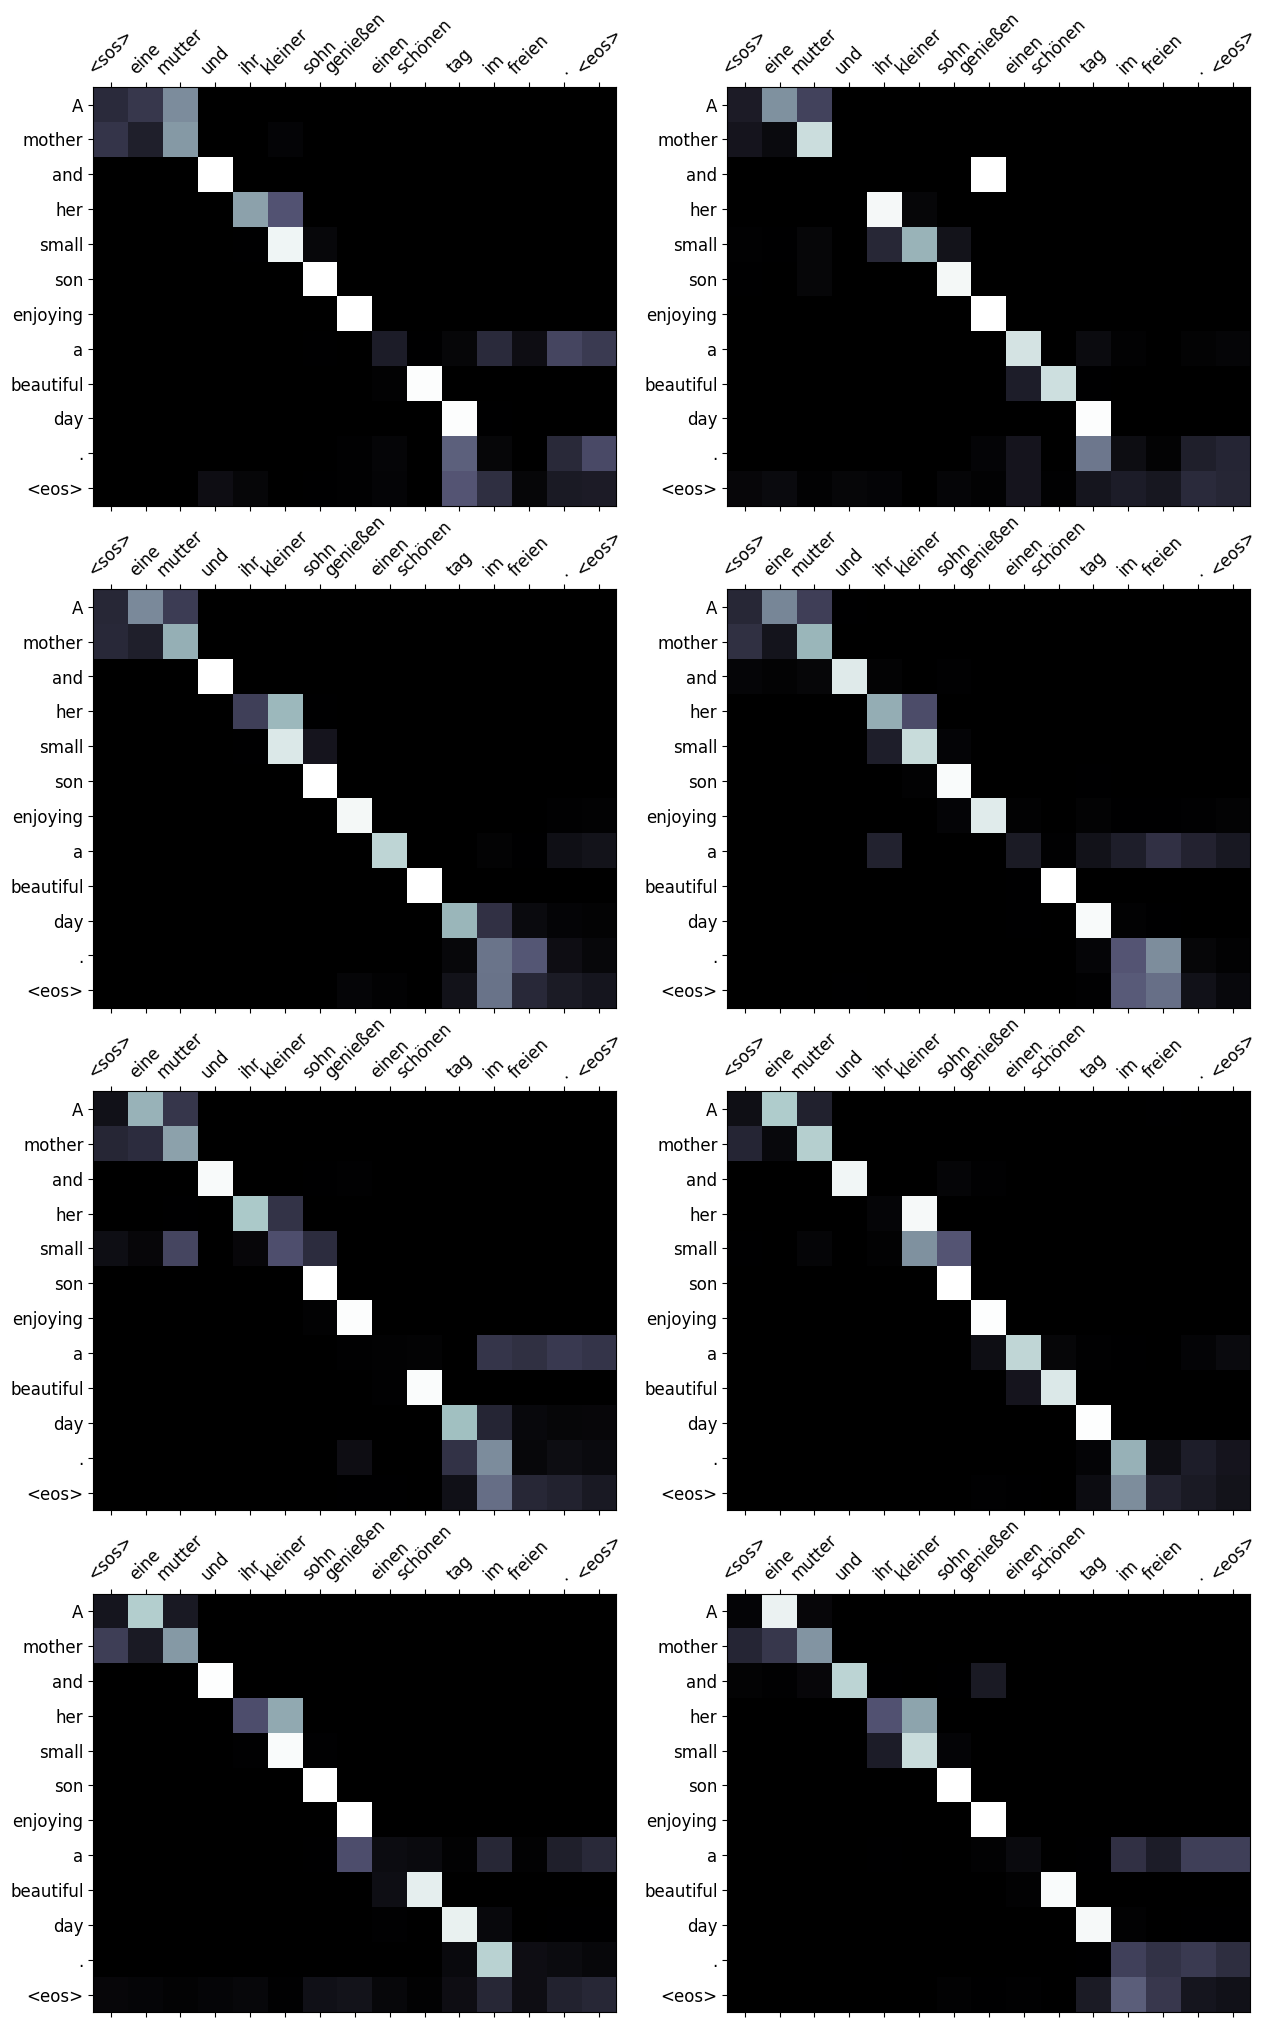

In [35]:
display_attention(tokenize_de(src_text), translation, attention)

#### <b>BLEU Score 계산</b>

* 학습된 트랜스포머(Transformer) 모델의 BLEU 스코어 계산
- 1-gram부터 4-gram까지의 정확도(precision)를 모두 종합하여 기하평균을 낸 뒤, 예측 문장이 정답보다 너무 짧을 경우 벌점(Brevity Penalty)을 적용한 값입니다. 모델의 전반적인 번역 성능을 나타내는 가장 중요한 지표입니다.
- BLEU-1 (55.43): 개별 단어(1-gram)의 정확도를 측정합니다. 이 점수가 높다는 것은 모델이 번역에 필요한 단어들을 대부분 올바르게 생성했다는 의미입니다. 문장의 충분성(adequacy)을 나타냅니다.

- BLEU-2 (43.63): 단어 2개로 이루어진 쌍(2-gram)의 정확도를 측정합니다. 점수가 내려갔지만, 이는 자연스러운 현상입니다. 이 점수는 모델이 단어 쌍을 얼마나 자연스럽게 구성하는지를 보여줍니다.

- BLEU-3 & BLEU-4 (34.15, 27.02): 3-gram, 4-gram은 더 긴 구문의 정확도를 측정합니다. n이 커질수록 정확히 일치하기 어려워져 점수는 계속 낮아집니다. 이 점수들이 높을수록 번역된 문장이 문법적으로 자연스럽고 유창(fluency)하다는 것을 의미합니다.

In [36]:
# torchmetrics 라이브러리가 설치되어 있어야 합니다. (pip install torchmetrics[text])
from torchmetrics.functional.text import bleu_score
from tqdm import tqdm
import math

def calculate_and_show_bleu(dataset, model, tokenize_de, tokenize_en, vocab_src, vocab_trg, device, max_len=50):
    
    trgs = []
    pred_trgs = []
    
    # dataset은 스트림(iterable) 형태이므로, 전체 길이를 미리 알기 위해 list로 변환합니다.
    data_list = list(dataset)
    total_count = len(data_list)
    
    print("BLEU 스코어 계산을 시작합니다...")

    for index, (src_text, trg_text) in enumerate(tqdm(data_list, desc="Calculating BLEU Score")):
        # 번역 수행 (결과는 토큰 리스트)
        # 이전에 정의한 translate_sentence 함수를 호출하여 하나의 소스 문장(src_text)을 번역하고, 결과로 토큰 리스트(pred_trg)를 받습니다
        pred_trg, _ = translate_sentence(src_text, model, tokenize_de, vocab_src, vocab_trg, device, max_len)
        pred_trg = pred_trg[:-1] # 번역 결과의 맨 마지막에 포함된 <eos> 토큰은 BLEU 점수 계산에 필요 없으므로 제거합니다.
        
        # 예측 결과는 공백으로 합쳐 문자열로 변환
        # bleu_score 함수는 문자열 형태의 문장을 입력 기대하므로, 예측된 토큰 리스트를 공백으로 합쳐 하나의 문자열로 만들어 pred_trgs 리스트에 추가.
        pred_trgs.append(" ".join(pred_trg))
        
        # 정답은 토큰화하지 않고 원본 문자열을 그대로 사용.
        # bleu_score는 하나의 예측에 대해 여러 개의 정답 문장이 있을 수 있는 경우를 대비하여, 정답을 리스트 형식으로 받음.
        trgs.append([trg_text])
        # --------------------
        
        if (index + 1) % 100 == 0:
            print(f"\n[{index + 1}/{total_count}]")
            print(f"예측: {' '.join(pred_trg)}") 
            print(f"정답: {trg_text}")
    
    print("\n--- BLEU 스코어 결과 ---")

    # Total BLEU Score (일반적으로 Cumulative BLEU-4를 의미)
    # n_gram 파라미터를 사용하여 BLEU-N 점수를 계산합니다. 
    # 이 점수는 누적(Cumulative) 점수로, n_gram=4는 1-gram부터 4-gram까지의 정확도를 모두 종합하여 계산한 최종 BLEU 점수를 의미함.
    total_bleu = bleu_score(pred_trgs, trgs, n_gram=4)
    print(f'Total BLEU Score = {total_bleu.item()*100:.2f}')
    
    bleu1 = bleu_score(pred_trgs, trgs, n_gram=1)
    bleu2 = bleu_score(pred_trgs, trgs, n_gram=2)
    bleu3 = bleu_score(pred_trgs, trgs, n_gram=3)
    bleu4 = bleu_score(pred_trgs, trgs, n_gram=4)
    
    print(f'Individual BLEU1 score = {bleu1.item()*100:.2f}')
    print(f'Individual BLEU2 score = {bleu2.item()*100:.2f}')
    print(f'Individual BLEU3 score = {bleu3.item()*100:.2f}')
    print(f'Individual BLEU4 score = {bleu4.item()*100:.2f}')
    
    print(f'Cumulative BLEU1 score = {bleu1.item()*100:.2f}')
    print(f'Cumulative BLEU2 score = {bleu2.item()*100:.2f}')
    print(f'Cumulative BLEU3 score = {bleu3.item()*100:.2f}')
    print(f'Cumulative BLEU4 score = {bleu4.item()*100:.2f}')

In [37]:
calculate_and_show_bleu(test_dataset, model, tokenize_de, tokenize_en, vocab_src, vocab_trg, device)

/home/ternary6/anaconda3/envs/rd_env/lib/python3.11/site-packages/torch/utils/data/datapipes/iter/combining.py:337: UserWarning: Some child DataPipes are not exhausted when __iter__ is called. We are resetting the buffer and each child DataPipe will read from the start again.
  warnings.warn("Some child DataPipes are not exhausted when __iter__ is called. We are resetting "


BLEU 스코어 계산을 시작합니다...


Calculating BLEU Score:  10%|█         | 104/1000 [00:04<00:36, 24.87it/s]


[100/1000]
예측: A little boy in a soccer uniform holding hands and crying .
정답: A young boy in a soccer uniform crying into his palms.


Calculating BLEU Score:  20%|██        | 204/1000 [00:08<00:33, 23.71it/s]


[200/1000]
예측: A man is making a giant board with a giant board .
정답: A man advertises with a giant sign tied onto his bicycle.


Calculating BLEU Score:  30%|███       | 304/1000 [00:12<00:28, 24.61it/s]


[300/1000]
예측: A group of young people drinking out of a <unk> .
정답: A group of young people take shots in a Mexican setting.


Calculating BLEU Score:  40%|████      | 405/1000 [00:16<00:21, 28.03it/s]


[400/1000]
예측: A smiling boy plays with ducks in the leaves .
정답: A smiling young boy plays in the leaves among the ducks.


Calculating BLEU Score:  50%|█████     | 505/1000 [00:20<00:19, 24.89it/s]


[500/1000]
예측: A woman is standing on a green field holding a white dog and pointing at a brown dog .
정답: A woman is standing in a green field holding a white dog and pointing at a brown dog.


Calculating BLEU Score:  60%|██████    | 604/1000 [00:24<00:16, 23.32it/s]


[600/1000]
예측: A guy in a yellow outfit stands behind the microphone in a tent .
정답: A guy with a yellow outfit on standing behind a microphone under a tent.


Calculating BLEU Score:  70%|███████   | 703/1000 [00:29<00:13, 21.92it/s]


[700/1000]
예측: Two motocross racers in protective gear , one of them is about to go off the dirt , and the other is looking down the motorcycle .
정답: Two motocross bikers wearing full protective gear, with one in midair after a jump and the other looking down at his motorcycle.


Calculating BLEU Score:  80%|████████  | 802/1000 [00:33<00:08, 22.70it/s]


[800/1000]
예측: A man is sitting on a platform with wheels and being pulled by a donkey .
정답: A man seated on a platform with wheels is being pulled by a burrow.


Calculating BLEU Score:  90%|█████████ | 904/1000 [00:38<00:04, 22.58it/s]


[900/1000]
예측: A person in blue is throwing her ball in a bowling alley .
정답: A person in blue is the only person currently throwing their ball at a bowling alley.


Calculating BLEU Score: 100%|██████████| 1000/1000 [00:42<00:00, 23.49it/s]



[1000/1000]
예측: A girl on a shore with a mountain in the background .
정답: A girl at the shore of a beach with a mountain in the distance.

--- BLEU 스코어 결과 ---
Total BLEU Score = 28.45
Individual BLEU1 score = 56.05
Individual BLEU2 score = 44.64
Individual BLEU3 score = 35.44
Individual BLEU4 score = 28.45
Cumulative BLEU1 score = 56.05
Cumulative BLEU2 score = 44.64
Cumulative BLEU3 score = 35.44
Cumulative BLEU4 score = 28.45
